#### Statistical Analysis using R

In [ ]:
chess_df<-read.csv('Cleaned_chess_df.csv',header=TRUE)

In [ ]:
names(chess_df)

[1] "rated"          "turns"          "victory_status" "winner"        
 [5] "white_rating"   "black_rating"   "moves"          "turns_binned"  
 [9] "initial_time"   "game_type"      "ECO_Names"      "rating_diff"   
[13] "rating_level"   "train_test"

In [ ]:
dim(chess_df)

[1] 17114    14

In [ ]:
sum(is.na(chess_df))

[1] 0

In [ ]:
chess_df<-chess_df[,!(names(chess_df) %in% c('rated','victory_status','moves'))]

In [ ]:
# processing categorical features
chess_df$game_type<-as.factor(chess_df$game_type)
chess_df$ECO_Names<-as.factor(chess_df$ECO_Names)
chess_df$rating_level<-as.factor(chess_df$rating_level)
chess_df$turns_binned<-as.factor(chess_df$turns_binned)
unique(chess_df$winner)
chess_df$winner_numeric<-ifelse(chess_df$winner == "white",1,ifelse(chess_df$winner == "black",0,NA))
unique(chess_df$winner_numeric)

[1] "black" "white"

[1] 0 1

In [ ]:
dim(chess_df)

[1] 17114    12

In [ ]:
head(chess_df,1)

,turns,winner,white_rating,black_rating,turns_binned,initial_time,game_type,ECO_Names,rating_diff,rating_level,train_test,winner_numeric
,<int>,<chr>,<int>,<int>,<fct>,<int>,<fct>,<fct>,<int>,<fct>,<int>,<dbl>
1,16,black,1322,1261,"(1.0, 33.0]",5,Blitz,Uncommon,61,Mid Rating,1,0


In [ ]:
# split the data in train and test files
train_df<-chess_df %>% filter(train_test == 1)
train_df<-train_df[,!(names(train_df) %in% c('train_test'))]

test_df <-chess_df %>% filter(train_test == 0)
test_df<-test_df[,!(names(test_df) %in% c('train_test'))]

In [ ]:
names(train_df)

[1] "turns"          "winner"         "white_rating"   "black_rating"  
 [5] "turns_binned"   "initial_time"   "game_type"      "ECO_Names"     
 [9] "rating_diff"    "rating_level"   "winner_numeric"

In [ ]:
c(dim(na.omit(train_df)),dim(train_df))

[1] 14579    11 14579    11

###### Multiple Logistic Regression

In [ ]:
logistic_model<-glm(winner_numeric~turns+white_rating+black_rating+initial_time+rating_diff,data=train_df,family="binomial")

In [ ]:
logistic_model


Call:  glm(formula = winner_numeric ~ turns + white_rating + black_rating + 
    initial_time + rating_diff, family = "binomial", data = train_df)

Coefficients:
 (Intercept)         turns  white_rating  black_rating  initial_time  
   0.3417931    -0.0028091     0.0040167    -0.0040885    -0.0002852  
 rating_diff  
   0.0002297  

Degrees of Freedom: 14578 Total (i.e. Null);  14573 Residual
Null Deviance:	    20170 
Residual Deviance: 17720 	AIC: 17740

In [ ]:
summary(logistic_model)


Call:
glm(formula = winner_numeric ~ turns + white_rating + black_rating + 
    initial_time + rating_diff, family = "binomial", data = train_df)

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)   0.3417931  0.1177500   2.903   0.0037 ** 
turns        -0.0028091  0.0005799  -4.844 1.27e-06 ***
white_rating  0.0040167  0.0001044  38.478  < 2e-16 ***
black_rating -0.0040885  0.0001046 -39.079  < 2e-16 ***
initial_time -0.0002852  0.0011719  -0.243   0.8077    
rating_diff   0.0002297  0.0001421   1.617   0.1060    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 20172  on 14578  degrees of freedom
Residual deviance: 17724  on 14573  degrees of freedom
AIC: 17736

Number of Fisher Scoring iterations: 4


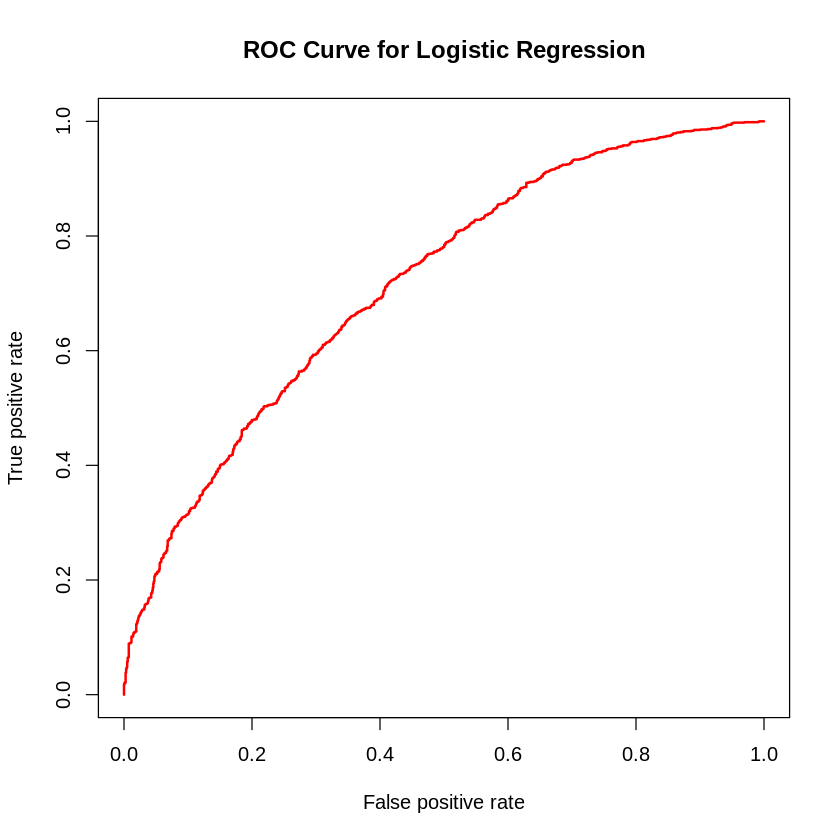

In [ ]:
logistic_pred<-predict(logistic_model,test_df,type="response")
pred<-prediction(logistic_pred,test_df$winner_numeric)
perf<-performance(pred,measure="tpr",x.measure="fpr")
plot(perf,col="red",lwd=2,main="ROC Curve for Logistic Regression")

###### Cross-Validation (k-Fold)

In [ ]:
cv_model<-train(winner_numeric~turns+white_rating+black_rating+initial_time+rating_diff,data=train_df,method="glm",family="binomial",trControl=trainControl(method="cv",number=10))

In [ ]:
cv_model

Generalized Linear Model 

14579 samples
    5 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 13121, 13121, 13121, 13122, 13121, 13121, ... 
Resampling results:

  RMSE       Rsquared   MAE      
  0.4588901  0.1558277  0.4220251


In [ ]:
summary(cv_model)


Call:
NULL

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)   0.3417931  0.1177500   2.903   0.0037 ** 
turns        -0.0028091  0.0005799  -4.844 1.27e-06 ***
white_rating  0.0040167  0.0001044  38.478  < 2e-16 ***
black_rating -0.0040885  0.0001046 -39.079  < 2e-16 ***
initial_time -0.0002852  0.0011719  -0.243   0.8077    
rating_diff   0.0002297  0.0001421   1.617   0.1060    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 20172  on 14578  degrees of freedom
Residual deviance: 17724  on 14573  degrees of freedom
AIC: 17736

Number of Fisher Scoring iterations: 4


###### Linear Discriminant Analysis (LDA) & Quadratic Discriminant Analysis (QDA)

In [ ]:
lda_model<-lda(winner~turns+white_rating+black_rating+initial_time+rating_diff,data=train_df)

In [ ]:
lda_model

Call:
lda(winner ~ turns + white_rating + black_rating + initial_time + 
    rating_diff, data = train_df)

Prior probabilities of groups:
    black     white 
0.4741752 0.5258248 

Group means:
         turns white_rating black_rating initial_time rating_diff
black 59.63966     1545.620     1636.469     13.74165    170.9271
white 56.54853     1633.002     1533.940     13.89225    178.6927

Coefficients of linear discriminants:
                       LD1
turns        -0.0033443152
white_rating  0.0042408245
black_rating -0.0043388329
initial_time -0.0003827855
rating_diff  -0.0001217031

In [ ]:
summary(lda_model)

        Length Class  Mode     
prior    2     -none- numeric  
counts   2     -none- numeric  
means   10     -none- numeric  
scaling  5     -none- numeric  
lev      2     -none- character
svd      1     -none- numeric  
N        1     -none- numeric  
call     3     -none- call     
terms    3     terms  call     
xlevels  0     -none- list     

In [ ]:
lda_predictions<-predict(lda_model,test_df)
head(lda_predictions$class)

[1] white black white white white black
Levels: black white

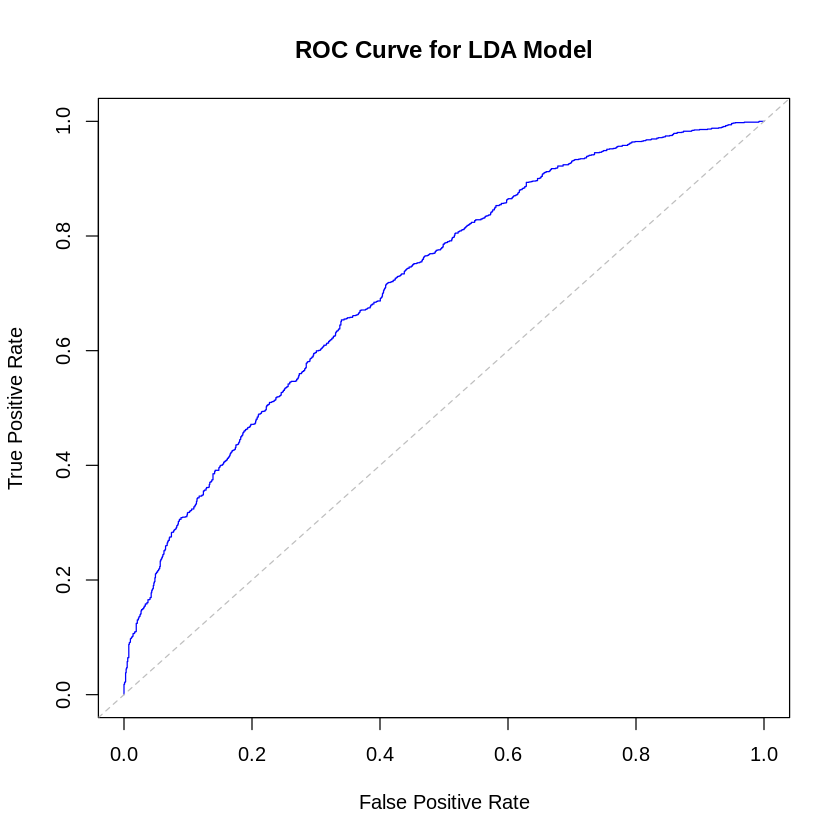

In [ ]:
lda_probabilities<-lda_predictions$posterior
pred<-prediction(lda_probabilities[,"white"],test_df$winner)
perf<-performance(pred,"tpr","fpr")
plot(perf,col="blue",main="ROC Curve for LDA Model",xlab="False Positive Rate",ylab="True Positive Rate")
abline(a=0,b=1,lty=2,col="gray")

In [ ]:
qda_model<-qda(winner~turns+white_rating+black_rating+initial_time+rating_diff,data=train_df)

In [ ]:
qda_model

Call:
qda(winner ~ turns + white_rating + black_rating + initial_time + 
    rating_diff, data = train_df)

Prior probabilities of groups:
    black     white 
0.4741752 0.5258248 

Group means:
         turns white_rating black_rating initial_time rating_diff
black 59.63966     1545.620     1636.469     13.74165    170.9271
white 56.54853     1633.002     1533.940     13.89225    178.6927

In [ ]:
summary(qda_model)

        Length Class  Mode     
prior    2     -none- numeric  
counts   2     -none- numeric  
means   10     -none- numeric  
scaling 50     -none- numeric  
ldet     2     -none- numeric  
lev      2     -none- character
N        1     -none- numeric  
call     3     -none- call     
terms    3     terms  call     
xlevels  0     -none- list     

In [ ]:
qda_predictions<-predict(qda_model,test_df)
head(qda_predictions$class)

[1] white black white white white black
Levels: black white

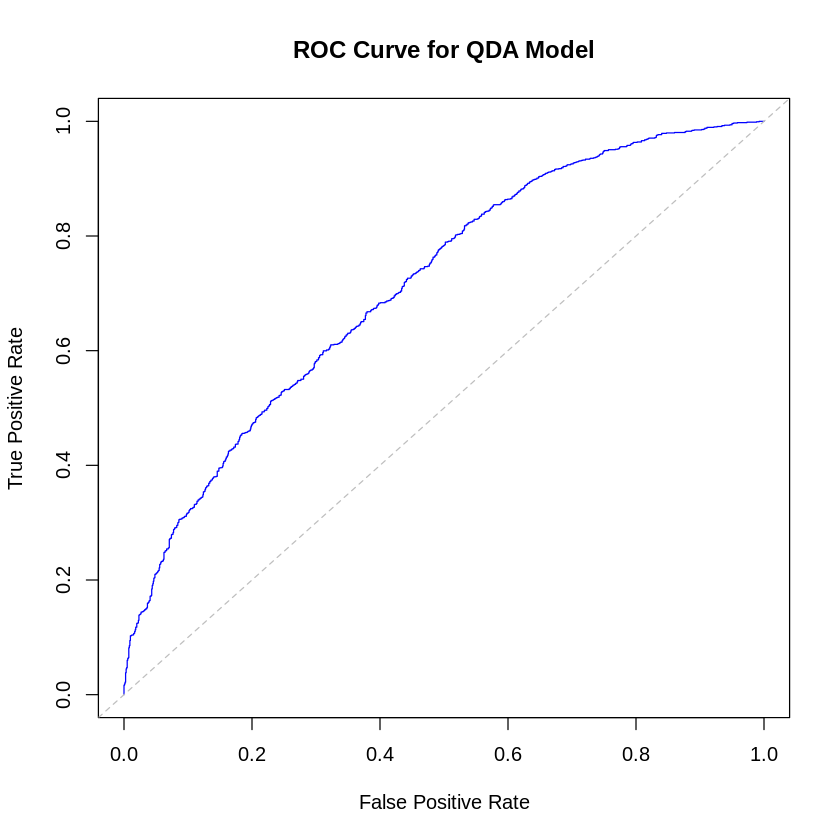

In [ ]:
qda_probabilities<-qda_predictions$posterior
pred<-prediction(qda_probabilities[,"white"],test_df$winner)
perf<-performance(pred,"tpr","fpr")
plot(perf,col="blue",main="ROC Curve for QDA Model",xlab="False Positive Rate",ylab="True Positive Rate")
abline(a=0,b=1,lty=2,col="gray")

###### Ridge Regression and Lasso

In [ ]:
x_train<-as.matrix(train_df[,c("turns","white_rating","black_rating","initial_time","rating_diff")])
y_train<-train_df$winner_numeric

In [ ]:
ridge_model<-cv.glmnet(x_train,y_train,alpha=0,family="binomial")

In [ ]:
ridge_model


Call:  cv.glmnet(x = x_train, y = y_train, alpha = 0, family = "binomial") 

Measure: Binomial Deviance 

      Lambda Index Measure       SE Nonzero
min 0.008901   100   1.220 0.004168       5
1se 0.014172    95   1.223 0.003826       5

In [ ]:
summary(ridge_model)

           Length Class  Mode     
lambda     100    -none- numeric  
cvm        100    -none- numeric  
cvsd       100    -none- numeric  
cvup       100    -none- numeric  
cvlo       100    -none- numeric  
nzero      100    -none- numeric  
call         5    -none- call     
name         1    -none- character
glmnet.fit  13    lognet list     
lambda.min   1    -none- numeric  
lambda.1se   1    -none- numeric  
index        2    -none- numeric  

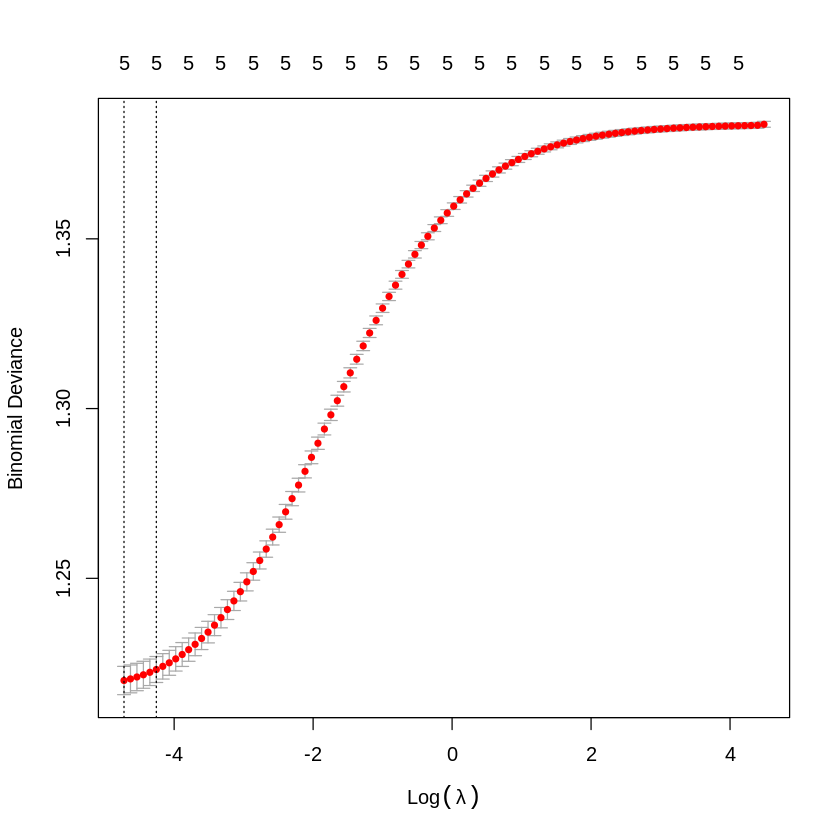

In [ ]:
plot(ridge_model)

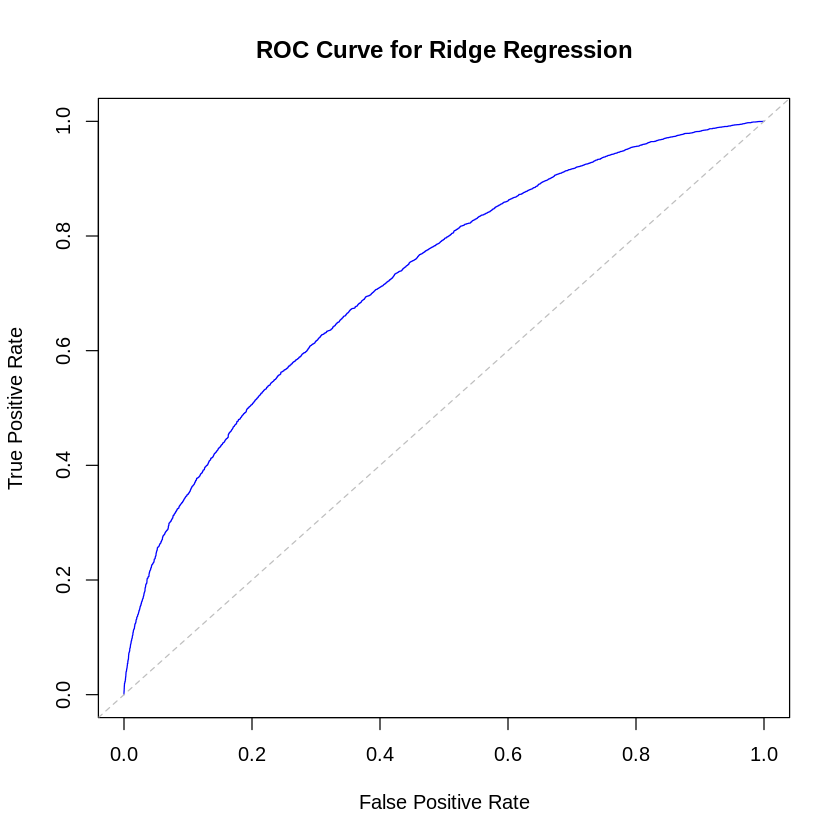

In [ ]:
best_lambda<-ridge_model$lambda.min
ridge_probabilities<-predict(ridge_model,newx=x_train,s=best_lambda,type="response")
roc_prediction<-prediction(ridge_probabilities,y_train)
roc_performance<-performance(roc_prediction,"tpr","fpr")
plot(roc_performance,col="blue",main="ROC Curve for Ridge Regression",xlab="False Positive Rate",ylab="True Positive Rate")
abline(a=0,b=1,lty=2,col="gray")

In [ ]:
lasso_model<-cv.glmnet(x_train,y_train,alpha=1,family="binomial")

In [ ]:
lasso_model


Call:  cv.glmnet(x = x_train, y = y_train, alpha = 1, family = "binomial") 

Measure: Binomial Deviance 

      Lambda Index Measure       SE Nonzero
min 0.001023    49   1.217 0.003077       4
1se 0.007923    27   1.219 0.002449       3

In [ ]:
summary(lasso_model)

           Length Class  Mode     
lambda     49     -none- numeric  
cvm        49     -none- numeric  
cvsd       49     -none- numeric  
cvup       49     -none- numeric  
cvlo       49     -none- numeric  
nzero      49     -none- numeric  
call        5     -none- call     
name        1     -none- character
glmnet.fit 13     lognet list     
lambda.min  1     -none- numeric  
lambda.1se  1     -none- numeric  
index       2     -none- numeric  

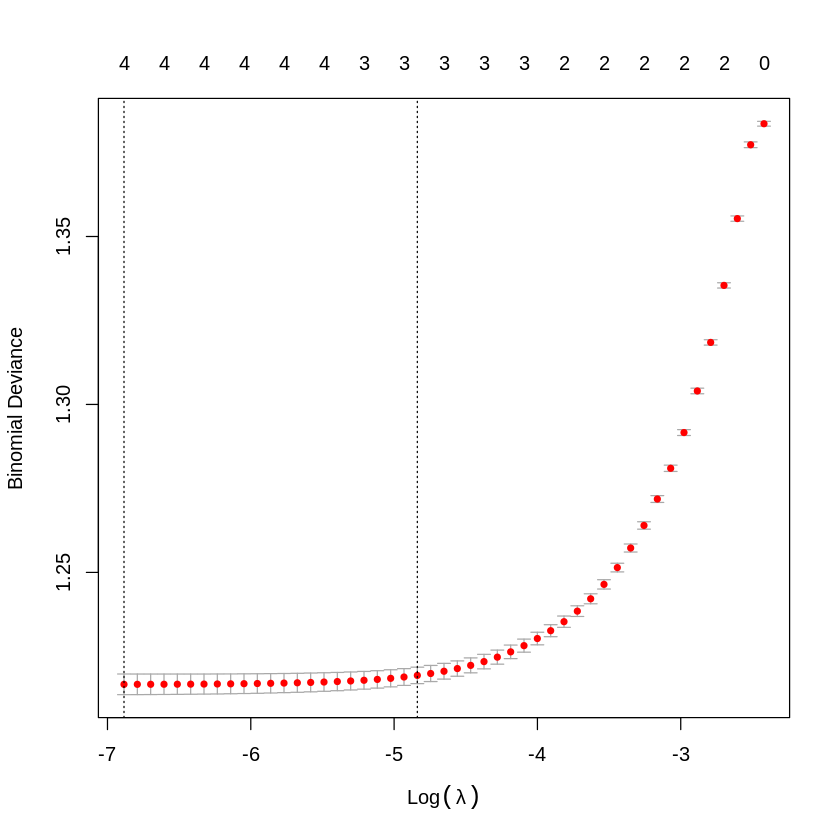

In [ ]:
plot(lasso_model)

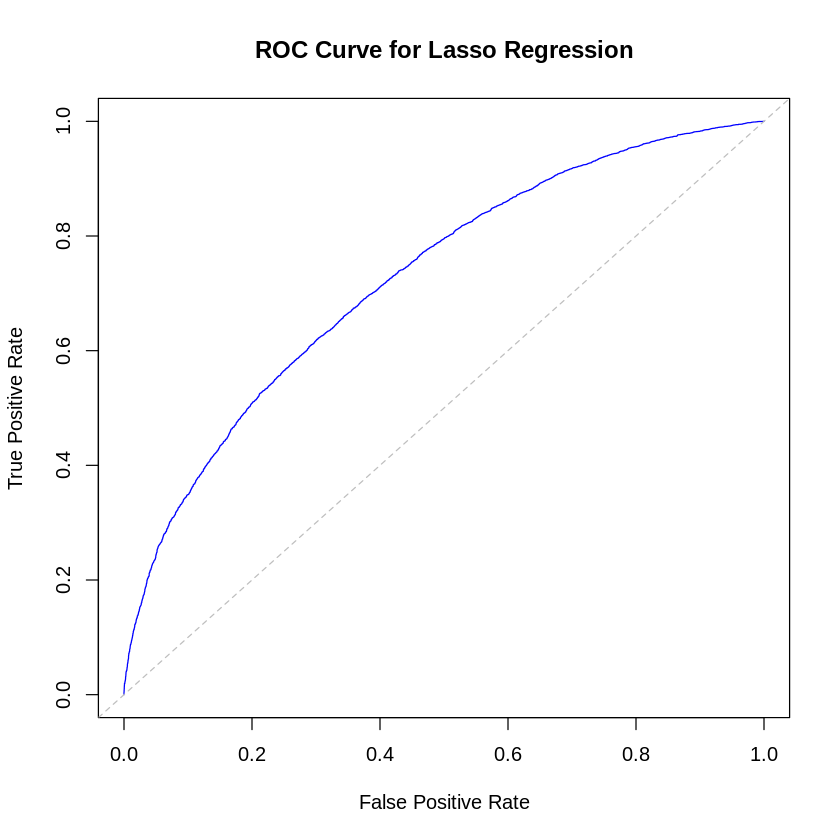

In [ ]:
best_lambda<-lasso_model$lambda.min
lasso_probabilities<-predict(lasso_model,newx=x_train,s=best_lambda,type="response")
roc_prediction<-prediction(lasso_probabilities,y_train)
roc_performance<-performance(roc_prediction,"tpr","fpr")
plot(roc_performance,col="blue",main="ROC Curve for Lasso Regression",xlab="False Positive Rate",ylab="True Positive Rate")
abline(a=0,b=1,lty=2,col="gray")

###### Best Subset Selection

In [ ]:
best_subset<-regsubsets(winner_numeric~turns+white_rating+black_rating+initial_time+rating_diff,data=train_df,nbest=1,nvmax=5)

In [ ]:
best_subset

Subset selection object
Call: regsubsets.formula(winner_numeric ~ turns + white_rating + black_rating + 
    initial_time + rating_diff, data = train_df, nbest = 1, nvmax = 5)
5 Variables  (and intercept)
             Forced in Forced out
turns            FALSE      FALSE
white_rating     FALSE      FALSE
black_rating     FALSE      FALSE
initial_time     FALSE      FALSE
rating_diff      FALSE      FALSE
1 subsets of each size up to 5
Selection Algorithm: exhaustive

In [ ]:
summary(best_subset)

Subset selection object
Call: regsubsets.formula(winner_numeric ~ turns + white_rating + black_rating + 
    initial_time + rating_diff, data = train_df, nbest = 1, nvmax = 5)
5 Variables  (and intercept)
             Forced in Forced out
turns            FALSE      FALSE
white_rating     FALSE      FALSE
black_rating     FALSE      FALSE
initial_time     FALSE      FALSE
rating_diff      FALSE      FALSE
1 subsets of each size up to 5
Selection Algorithm: exhaustive
         turns white_rating black_rating initial_time rating_diff
1  ( 1 ) " "   " "          "*"          " "          " "        
2  ( 1 ) " "   "*"          "*"          " "          " "        
3  ( 1 ) "*"   "*"          "*"          " "          " "        
4  ( 1 ) "*"   "*"          "*"          " "          "*"        
5  ( 1 ) "*"   "*"          "*"          "*"          "*"        

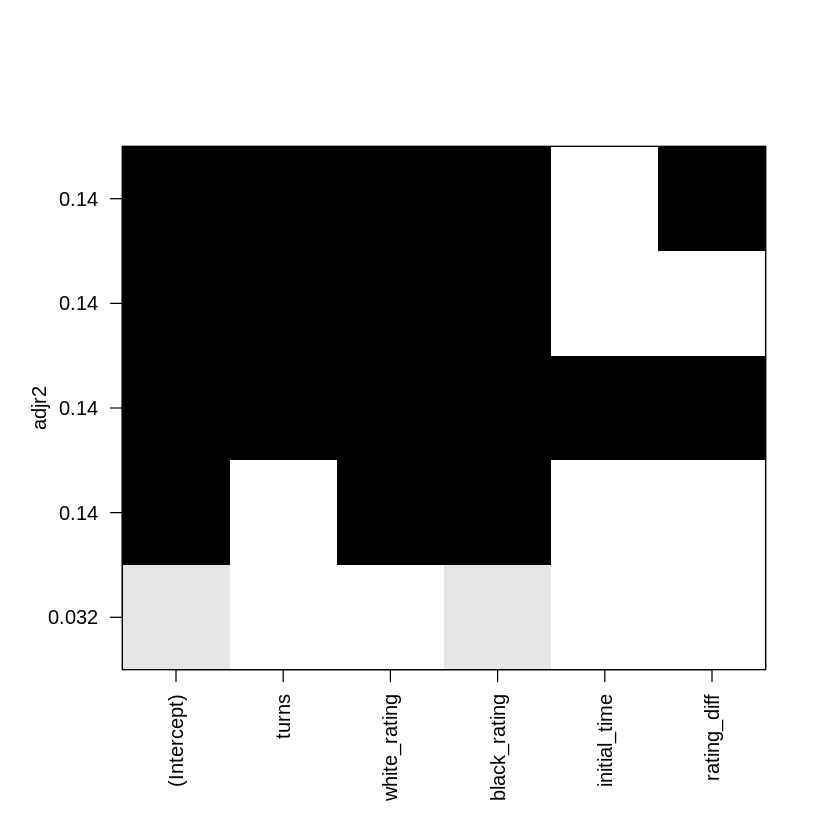

In [ ]:
plot(best_subset,scale="adjr2")

###### Forward Stepwise Selection

In [ ]:
empty_model<-glm(winner_numeric~1,data=train_df,family="binomial")
full_model<-glm(winner_numeric~turns+white_rating+black_rating+initial_time+rating_diff,data=train_df,family="binomial")

In [ ]:
forward_model<-step(empty_model,scope=list(lower=empty_model,upper=full_model),direction="forward")

Start:  AIC=20173.88
winner_numeric ~ 1

               Df Deviance   AIC
+ black_rating  1    19702 19706
+ white_rating  1    19831 19835
+ turns         1    20137 20141
+ rating_diff   1    20165 20169
<none>               20172 20174
+ initial_time  1    20172 20176

Step:  AIC=19706
winner_numeric ~ black_rating

               Df Deviance   AIC
+ white_rating  1    17752 17758
+ rating_diff   1    19693 19699
+ turns         1    19694 19700
<none>               19702 19706
+ initial_time  1    19701 19707

Step:  AIC=17757.84
winner_numeric ~ black_rating + white_rating

               Df Deviance   AIC
+ turns         1    17727 17735
+ rating_diff   1    17748 17756
<none>               17752 17758
+ initial_time  1    17752 17760

Step:  AIC=17734.77
winner_numeric ~ black_rating + white_rating + turns

               Df Deviance   AIC
+ rating_diff   1    17724 17734
<none>               17727 17735
+ initial_time  1    17727 17737

Step:  AIC=17734.19
winner_numeric ~ blac

In [ ]:
forward_model


Call:  glm(formula = winner_numeric ~ black_rating + white_rating + 
    turns + rating_diff, family = "binomial", data = train_df)

Coefficients:
 (Intercept)  black_rating  white_rating         turns   rating_diff  
   0.3361295    -0.0040878     0.0040172    -0.0028058     0.0002276  

Degrees of Freedom: 14578 Total (i.e. Null);  14574 Residual
Null Deviance:	    20170 
Residual Deviance: 17720 	AIC: 17730

In [ ]:
summary(forward_model)


Call:
glm(formula = winner_numeric ~ black_rating + white_rating + 
    turns + rating_diff, family = "binomial", data = train_df)

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)   0.3361295  0.1154253   2.912  0.00359 ** 
black_rating -0.0040878  0.0001046 -39.086  < 2e-16 ***
white_rating  0.0040172  0.0001044  38.491  < 2e-16 ***
turns        -0.0028058  0.0005798  -4.840  1.3e-06 ***
rating_diff   0.0002276  0.0001418   1.605  0.10850    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 20172  on 14578  degrees of freedom
Residual deviance: 17724  on 14574  degrees of freedom
AIC: 17734

Number of Fisher Scoring iterations: 4


###### Backward Stepwise Selection

In [ ]:
backward_model<-step(full_model,direction="backward")

Start:  AIC=17736.13
winner_numeric ~ turns + white_rating + black_rating + initial_time + 
    rating_diff

               Df Deviance   AIC
- initial_time  1    17724 17734
<none>               17724 17736
- rating_diff   1    17727 17737
- turns         1    17748 17758
- white_rating  1    19684 19694
- black_rating  1    19760 19770

Step:  AIC=17734.19
winner_numeric ~ turns + white_rating + black_rating + rating_diff

               Df Deviance   AIC
<none>               17724 17734
- rating_diff   1    17727 17735
- turns         1    17748 17756
- white_rating  1    19687 19695
- black_rating  1    19762 19770


In [ ]:
backward_model


Call:  glm(formula = winner_numeric ~ turns + white_rating + black_rating + 
    rating_diff, family = "binomial", data = train_df)

Coefficients:
 (Intercept)         turns  white_rating  black_rating   rating_diff  
   0.3361295    -0.0028058     0.0040172    -0.0040878     0.0002276  

Degrees of Freedom: 14578 Total (i.e. Null);  14574 Residual
Null Deviance:	    20170 
Residual Deviance: 17720 	AIC: 17730

In [ ]:
summary(backward_model)


Call:
glm(formula = winner_numeric ~ turns + white_rating + black_rating + 
    rating_diff, family = "binomial", data = train_df)

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)   0.3361295  0.1154253   2.912  0.00359 ** 
turns        -0.0028058  0.0005798  -4.840  1.3e-06 ***
white_rating  0.0040172  0.0001044  38.491  < 2e-16 ***
black_rating -0.0040878  0.0001046 -39.086  < 2e-16 ***
rating_diff   0.0002276  0.0001418   1.605  0.10850    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 20172  on 14578  degrees of freedom
Residual deviance: 17724  on 14574  degrees of freedom
AIC: 17734

Number of Fisher Scoring iterations: 4


###### Partial Least Squares (PLS)

In [ ]:
pls_model<-plsr(winner_numeric~turns+white_rating+black_rating+initial_time+rating_diff,data=train_df,validation="CV")

In [ ]:
pls_model

Partial least squares regression, fitted with the kernel algorithm.
Cross-validated using 10 random segments.
Call:
plsr(formula = winner_numeric ~ turns + white_rating + black_rating +     initial_time + rating_diff, data = train_df, validation = "CV")

In [ ]:
summary(pls_model)

Data: 	X dimension: 14579 5 
	Y dimension: 14579 1
Fit method: kernelpls
Number of components considered: 5

VALIDATION: RMSEP
Cross-validated using 10 random segments.
       (Intercept)  1 comps  2 comps  3 comps  4 comps  5 comps
CV          0.4994   0.4632   0.4623   0.4622   0.4619   0.4619
adjCV       0.4994   0.4631   0.4623   0.4622   0.4619   0.4619

TRAINING: % variance explained
                1 comps  2 comps  3 comps  4 comps  5 comps
X                  17.3    82.47    99.34    99.86    100.0
winner_numeric     14.1    14.34    14.39    14.50     14.5


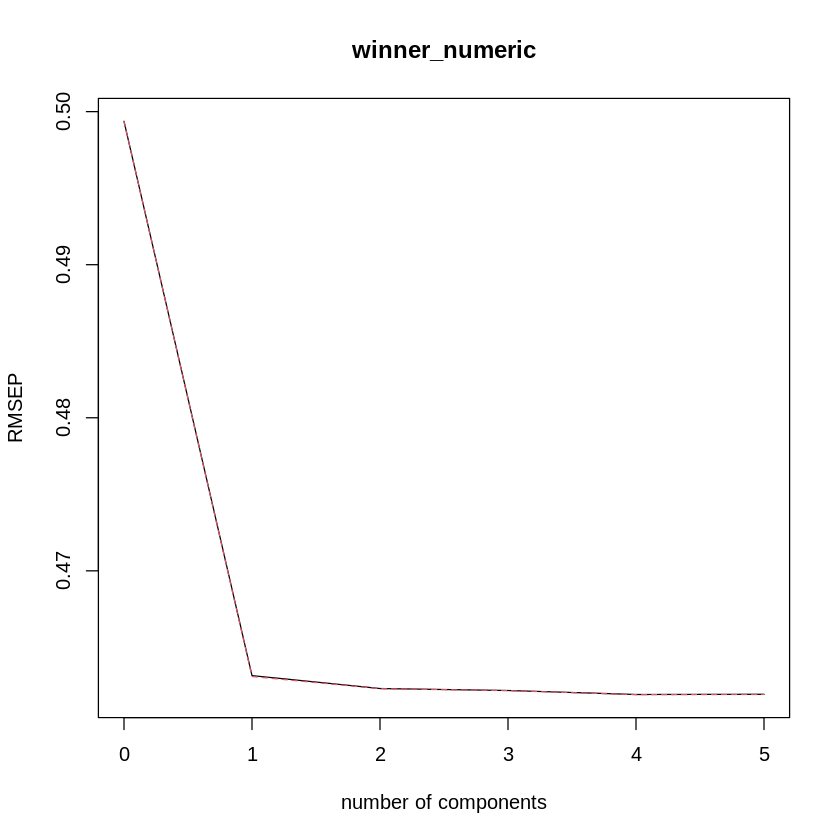

In [ ]:
# Root Mean Squared Error of Prediction
validationplot(pls_model,val.type="RMSEP")

###### K-Nearest Neighbors (KNN)

In [ ]:
x_train<-train_df[,c("turns","white_rating","black_rating","initial_time","rating_diff")]
x_test<-test_df[,c("turns","white_rating","black_rating","initial_time","rating_diff")]

y_train<-train_df$winner_numeric

In [ ]:
knn_predictions<-knn(train=x_train,test=x_test,cl=y_train,k=5)

In [ ]:
knn_predictions

[1] 1 1 1 1 1 0 1 0 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 0 0 0 1 0 0 1 0 0 1 0 0 1 0
  [38] 1 0 1 0 1 0 1 1 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 1 0 0 0 1 1 0 1 1 1
  [75] 0 0 0 0 1 1 1 0 1 1 1 1 0 1 1 0 0 0 1 1 0 0 0 1 1 1 0 1 0 1 0 0 0 1 1 1 1
 [112] 0 0 1 1 0 1 1 1 0 1 1 0 1 0 1 0 1 1 0 1 1 1 1 1 1 1 0 0 1 0 1 0 0 0 0 1 0
 [149] 0 1 1 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 1 1 1 1 0 1
 [186] 1 0 1 0 0 1 1 1 1 0 1 1 1 0 1 0 0 0 0 0 1 1 1 0 1 0 0 1 0 0 1 1 0 1 0 0 1
 [223] 1 0 1 1 0 1 0 0 0 1 0 0 0 0 1 1 0 1 0 0 0 1 1 1 1 1 0 1 1 1 0 0 0 0 0 0 0
 [260] 1 1 1 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 1 1 1 0 1
 [297] 0 1 0 1 1 0 1 0 1 0 1 1 0 0 0 0 1 1 1 0 1 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1
 [334] 1 0 1 0 0 1 1 1 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 1 1 1 0 1 0 0
 [371] 1 0 1 0 0 1 0 1 1 1 1 0 0 1 0 1 1 0 0 0 0 1 1 0 0 0 1 1 1 1 0 0 1 1 0 0 1
 [408] 1 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 1 0 1 1 0 1 0 1 0 1 0 1 0 1 1 1 0 1 1
 [445] 0 1 1 0 1 1 0 1 1 1 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 1 1 0 1 0 1 0 1 1 1 1
 [482] 0 1 1 0 0 1 1 1 1 1 0 0 1 1 1 0 0 1 1 0 1 1 1 1 1 0 0 0 0 1 0 0 1 0 0 0 1
 [519] 0 1 0 1 1 1 1 0 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 0 0 0 0 0 1 0 1 1 0 1 0 0 1
 [556] 0 1 0 0 1 0 1 1 1 0 0 1 0 0 1 1 1 0 1 0 0 1 0 0 0 1 1 0 1 1 0 0 0 0 0 1 1
 [593] 0 0 1 1 1 1 1 1 1 1 0 0 1 0 0 0 1 1 1 1 0 1 0 1 1 0 1 1 0 1 0 0 1 0 1 1 0
 [630] 1 1 0 0 0 1 1 0 0 1 0 0 0 1 1 1 0 1 0 1 0 1 0 0 1 1 0 1 1 1 0 1 1 1 1 0 0
 [667] 1 1 0 0 1 0 1 1 0 1 1 0 1 1 0 1 0 1 1 1 1 0 0 0 0 1 0 0 1 1 1 0 1 0 0 1 1
 [704] 0 1 1 0 0 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 0 1 1 1 0
 [741] 1 1 1 0 1 0 1 1 1 1 0 0 1 0 1 1 1 0 1 0 0 0 1 1 1 1 1 1 0 0 0 1 0 1 0 1 1
 [778] 1 0 0 0 1 0 1 1 1 1 1 0 0 0 0 1 1 0 1 0 1 1 1 1 0 1 0 0 1 0 1 1 0 1 1 1 1
 [815] 0 0 0 1 1 0 0 0 0 1 1 0 1 1 0 0 1 1 1 0 1 1 0 1 1 0 0 0 1 1 1 0 0 1 1 1 0
 [852] 1 1 0 0 1 0 0 0 1 1 0 1 1 0 1 1 0 0 1 0 0 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1
 [889] 1 0 1 1 0 1 1 0 1 1 0 1 0 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 1 0 1 0 0 0 1
 [926] 1 1 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 1 1 1 1 1 1 1 0 1 0 0 0 1 1 1 0 0 0 1 0
 [963] 1 0 0 0 0 0 1 0 1 1 1 0 1 0 0 0 1 0 1 0 1 0 1 1 1 0 1 1 0 0 0 1 1 0 1 1 0
[1000] 0 0 1 0 0 1 1 0 0 1 1 1 1 0 1 1 1 1 0 0 0 0 0 1 1 0 1 0 1 0 1 0 1 0 0 0 0
[1037] 0 0 1 1 0 1 0 0 0 1 0 1 1 1 0 0 0 0 1 0 1 0 0 0 1 0 1 0 1 0 1 1 0 1 1 0 1
[1074] 1 1 0 1 1 1 0 1 0 1 1 0 1 0 1 1 1 0 1 0 0 1 0 1 0 0 1 1 0 1 1 1 1 0 1 0 1
[1111] 1 1 1 0 0 0 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 0 0 1 0
[1148] 1 1 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 0 0 0 1 0 1 0 0 0 1 1 0 0 1 0 1 0 1 0 1
[1185] 0 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 0 1 1 0 1 0
[1222] 0 1 0 1 1 1 1 0 1 0 0 1 0 0 0 0 1 1 1 0 1 1 1 1 1 1 0 0 0 1 1 0 0 1 0 0 1
[1259] 1 1 1 0 1 1 1 0 1 0 1 1 0 1 0 1 0 0 0 1 1 0 0 1 1 0 1 0 0 1 0 1 0 1 0 1 1
[1296] 1 1 1 0 0 1 1 1 0 0 1 0 1 0 0 1 1 0 1 0 0 1 0 1 1 1 1 0 0 1 0 1 0 0 0 0 0
[1333] 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0 1 1 1 1 0 1 1 0 1 1 0 0 1 0
[1370] 1 0 1 1 0 0 1 1 0 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 0 0 0 1 0 1 0 0
[1407] 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 0 1 0 1 0 1 1 0 1 0 0 0 1 0 1 1 1 1 0 1 0
[1444] 0 1 0 0 0 0 1 1 0 0 0 1 1 0 1 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1 0 0 0 1 0 1
[1481] 1 1 1 1 1 0 1 0 1 0 1 1 1 0 0 1 0 1 1 0 1 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 1
[1518] 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1 0 1 0 1 1 1 1 1 0 0 0 1 1 1 0 0 1 1 1 1
[1555] 0 0 1 0 0 0 1 0 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 0 0 1 1 0 0 0 1 0 1 0 1 1
[1592] 0 1 1 1 1 1 0 0 1 0 0 1 0 1 1 1 0 1 1 0 1 1 1 0 1 0 1 1 0 1 1 1 1 1 0 0 0
[1629] 1 0 0 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 0 1 1 0 0 1
[1666] 1 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0 1 1 1 0 1 0 1 0 0 1 0 1 0 0 0 0 1 1 0 0
[1703] 0 1 0 1 0 1 1 0 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 0 0 1
[1740] 0 1 0 0 1 1 1 1 0 0 1 0 1 1 0 1 0 1 1 0 1 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0
[1777] 1 1 0 1 0 0 1 1 0 1 1 1 1 0 1 0 1 1 0 1 1 0 1 0 1 0 1 0 1 0 0 1 1 1 0 1 0
[1814] 0 1 1 0 1 0 1 0 0 1 0 0 1 1

In [ ]:
summary(knn_predictions)

0    1 
1173 1362

In [ ]:
head(knn_predictions)

[1] 1 1 1 1 1 0
Levels: 0 1

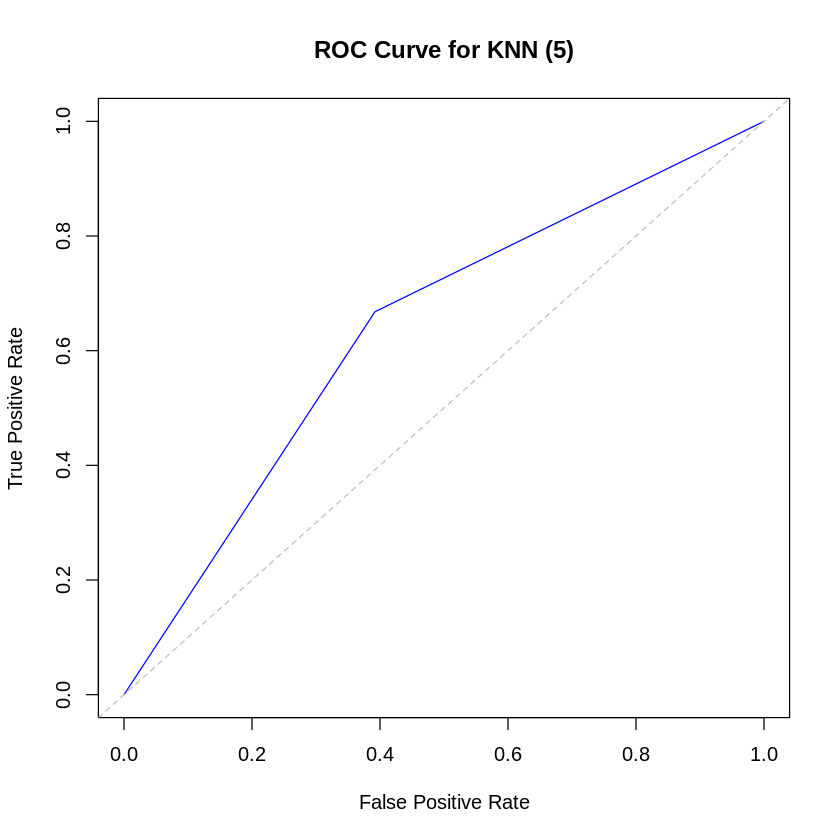

In [ ]:
knn_probabilities<-ifelse(knn_predictions == 1,1,0)
roc_prediction<-prediction(knn_probabilities,test_df$winner_numeric)
roc_performance<-performance(roc_prediction,"tpr","fpr")
plot(roc_performance,col="blue",main="ROC Curve for KNN (5)",xlab="False Positive Rate",ylab="True Positive Rate")
abline(a=0,b=1,lty=2,col="gray")

###### Tree Based Models (Classification Trees and Random Forests)

In [ ]:
tree_model<-rpart(winner_numeric~turns+white_rating+black_rating+initial_time+rating_diff,data=train_df,method='class')

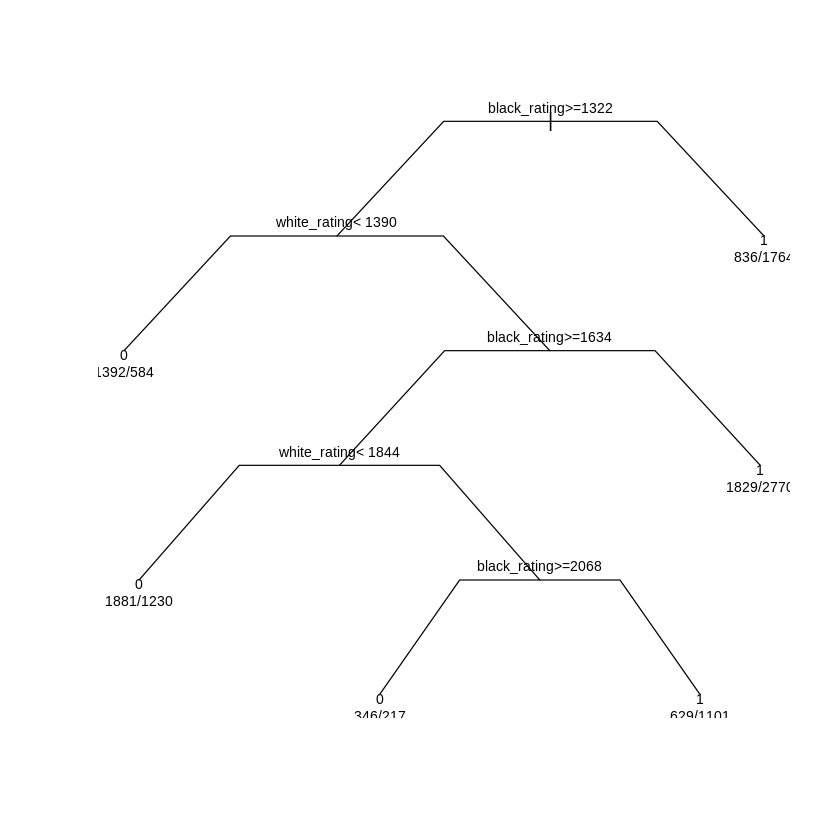

In [ ]:
plot(tree_model,uniform=TRUE,branch=0.5,compress=TRUE)
text(tree_model,use.n=TRUE,cex=0.7)

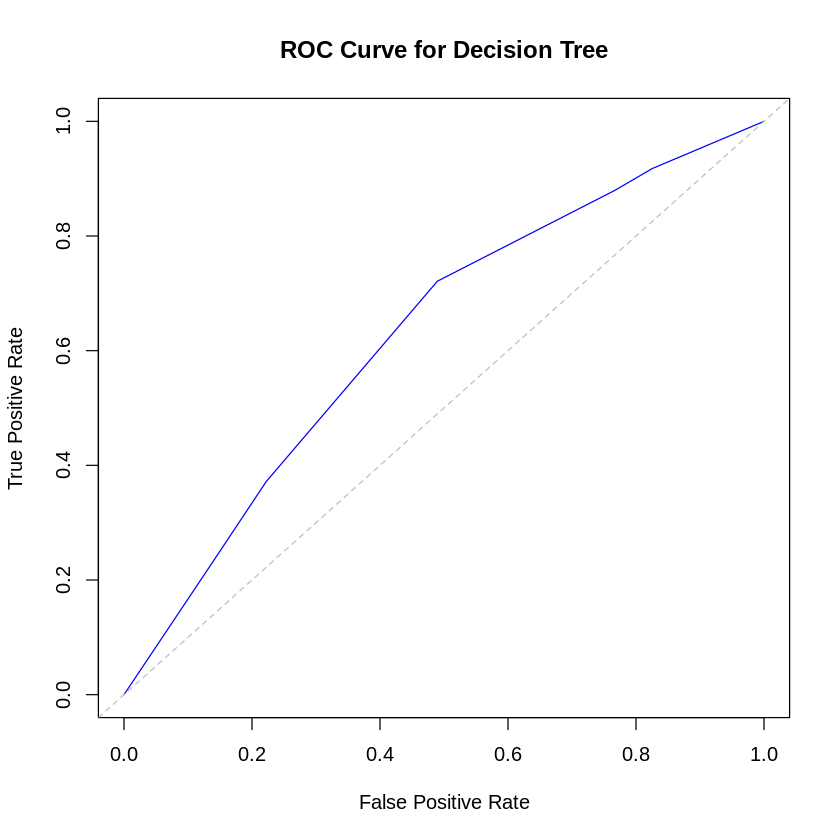

In [ ]:
tree_probabilities<-predict(tree_model,newdata=x_test,type="prob")
tree_prob_for_roc<-tree_probabilities[,"1"]
roc_prediction<-prediction(tree_prob_for_roc,test_df$winner_numeric)
roc_performance<-performance(roc_prediction,"tpr","fpr")
plot(roc_performance,col="blue",main="ROC Curve for Decision Tree",xlab="False Positive Rate",ylab="True Positive Rate")
abline(a=0,b=1,lty=2,col="gray")

In [ ]:
train_df$winner_factor<-as.factor(train_df$winner)
test_df$winner_factor<-as.factor(test_df$winner)

In [ ]:
rf_model<-randomForest(winner_factor~turns+white_rating+black_rating+initial_time+rating_diff,data=train_df,ntree=500)

In [ ]:
rf_model


Call:
 randomForest(formula = winner_factor ~ turns + white_rating +      black_rating + initial_time + rating_diff, data = train_df,      ntree = 500, method = "class") 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 2

        OOB estimate of  error rate: 30.61%
Confusion matrix:
      black white class.error
black  4592  2321   0.3357442
white  2141  5525   0.2792852

In [ ]:
summary(rf_model)

                Length Class  Mode     
call                5  -none- call     
type                1  -none- character
predicted       14579  factor numeric  
err.rate         1500  -none- numeric  
confusion           6  -none- numeric  
votes           29158  matrix numeric  
oob.times       14579  -none- numeric  
classes             2  -none- character
importance          5  -none- numeric  
importanceSD        0  -none- NULL     
localImportance     0  -none- NULL     
proximity           0  -none- NULL     
ntree               1  -none- numeric  
mtry                1  -none- numeric  
forest             14  -none- list     
y               14579  factor numeric  
test                0  -none- NULL     
inbag               0  -none- NULL     
terms               3  terms  call     

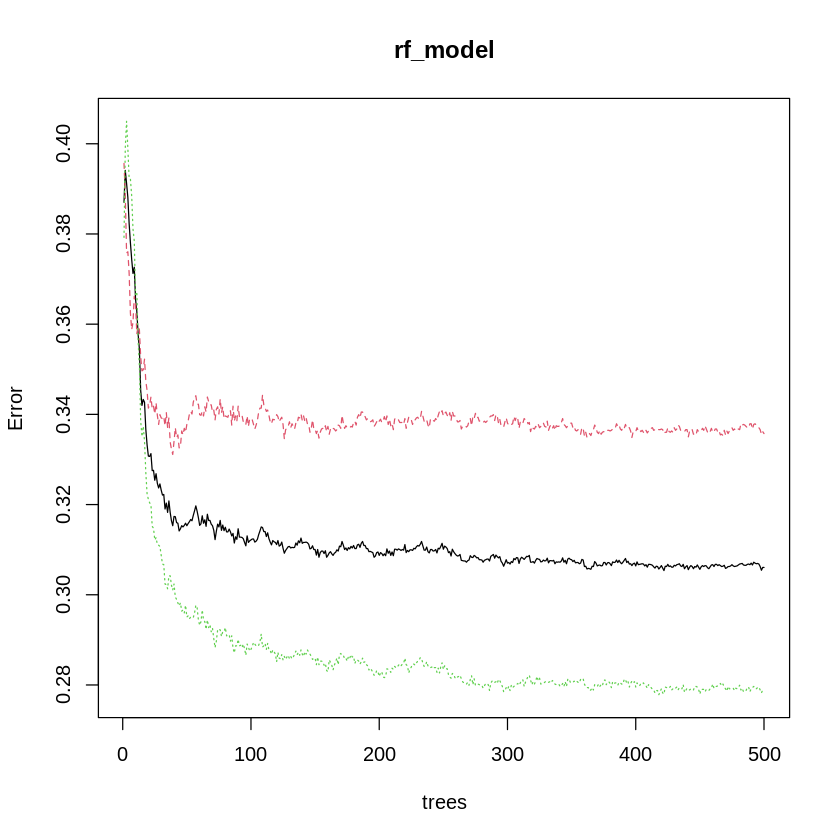

In [ ]:
plot(rf_model)

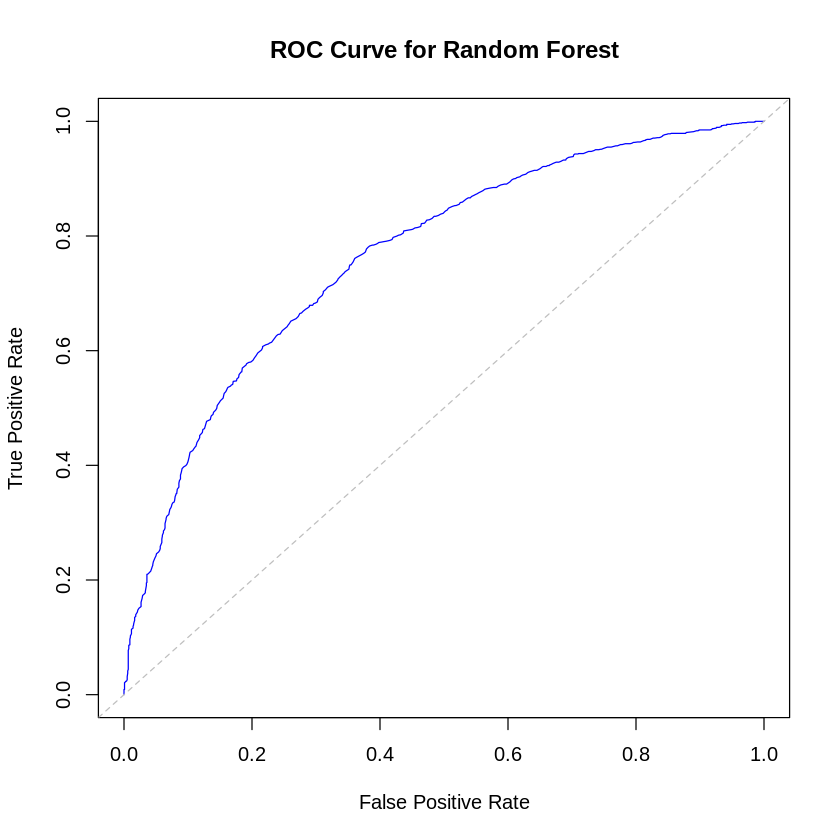

In [ ]:
rf_probabilities<-predict(rf_model,newdata=test_df,type="prob")
rf_prob_for_roc<-rf_probabilities[,"white"]
roc_prediction<-prediction(rf_prob_for_roc,test_df$winner_factor)
roc_performance<-performance(roc_prediction,"tpr","fpr")
plot(roc_performance,col="blue",main="ROC Curve for Random Forest",xlab="False Positive Rate",ylab="True Positive Rate")
abline(a=0,b=1,lty=2,col="gray")

###### Bagging

In [ ]:
bagging_model<-randomForest(winner_factor~turns+white_rating+black_rating+initial_time+rating_diff,data=train_df,ntree=500,mtry=5,importance=TRUE)

In [ ]:
bagging_model


Call:
 randomForest(formula = winner_factor ~ turns + white_rating +      black_rating + initial_time + rating_diff, data = train_df,      ntree = 500, mtry = 5, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 5

        OOB estimate of  error rate: 32.15%
Confusion matrix:
      black white class.error
black  4486  2427   0.3510777
white  2260  5406   0.2948082

In [ ]:
summary(bagging_model)

                Length Class  Mode     
call                6  -none- call     
type                1  -none- character
predicted       14579  factor numeric  
err.rate         1500  -none- numeric  
confusion           6  -none- numeric  
votes           29158  matrix numeric  
oob.times       14579  -none- numeric  
classes             2  -none- character
importance         20  -none- numeric  
importanceSD       15  -none- numeric  
localImportance     0  -none- NULL     
proximity           0  -none- NULL     
ntree               1  -none- numeric  
mtry                1  -none- numeric  
forest             14  -none- list     
y               14579  factor numeric  
test                0  -none- NULL     
inbag               0  -none- NULL     
terms               3  terms  call     

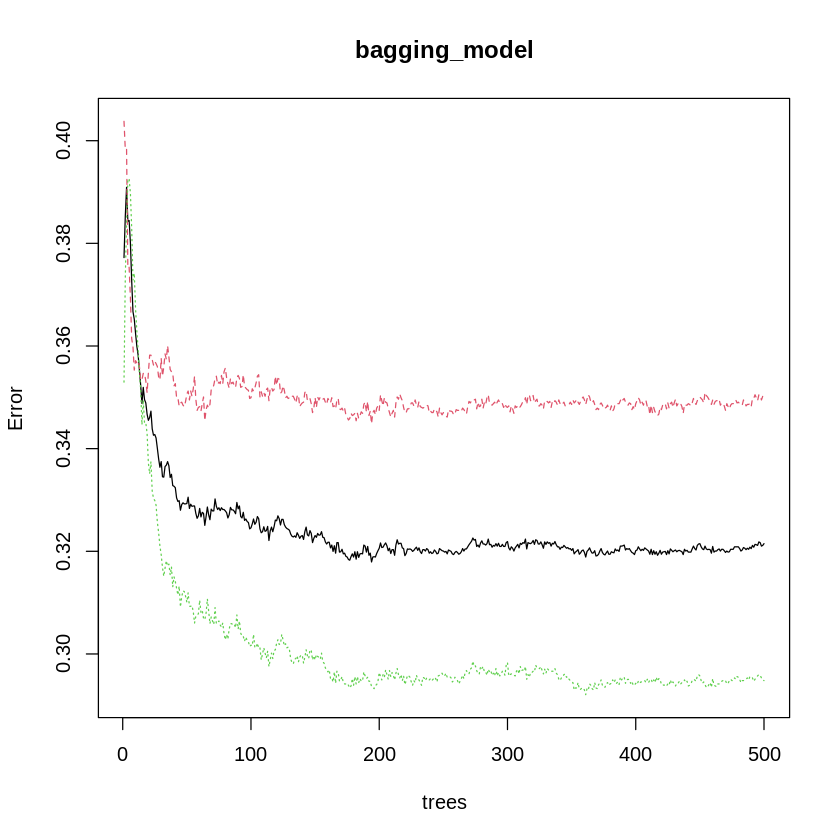

In [ ]:
plot(bagging_model)

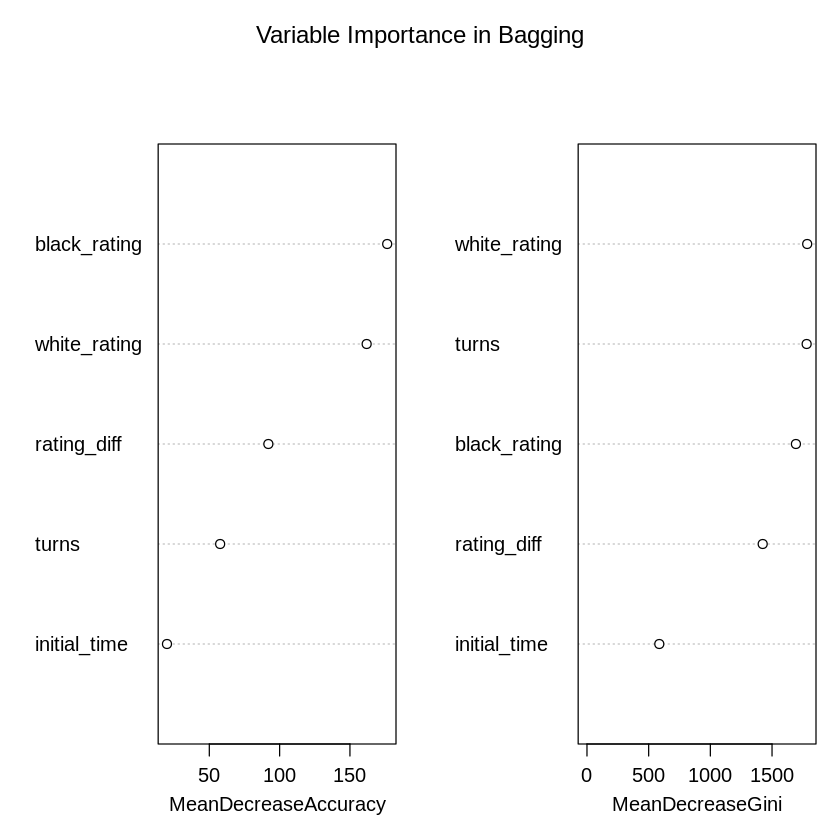

In [ ]:
varImpPlot(bagging_model,main="Variable Importance in Bagging")

###### Boosting

In [ ]:
c(train_df$winner_numeric[0:10],train_df$winner[0:10])

[1] "0"     "1"     "1"     "1"     "0"     "0"     "1"     "1"     "0"    
[10] "0"     "black" "white" "white" "white" "black" "black" "white" "white"
[19] "black" "black"

In [ ]:
x_train<-as.matrix(train_df[,c("turns","white_rating","black_rating","initial_time","rating_diff")])
y_train<-train_df$winner_numeric

In [ ]:
dtrain<-xgb.DMatrix(data=x_train,label=y_train)
boosting_model<-xgb.train(list(objective="binary:logistic",eta=0.1,max_depth=6),dtrain,nrounds=100)

In [ ]:
boosting_model

##### xgb.Booster
raw: 327.6 Kb 
call:
  xgb.train(params = list(objective = "binary:logistic", eta = 0.1, 
    max_depth = 6), data = dtrain, nrounds = 100)
params (as set within xgb.train):
  objective = "binary:logistic", eta = "0.1", max_depth = "6", validate_parameters = "TRUE"
xgb.attributes:
  niter
callbacks:
  cb.print.evaluation(period = print_every_n)
# of features: 5 
niter: 100
nfeatures : 5 

In [ ]:
summary(boosting_model)

              Length Class              Mode       
handle             1 xgb.Booster.handle externalptr
raw           335382 -none-             raw        
niter              1 -none-             numeric    
call               4 -none-             call       
params             4 -none-             list       
callbacks          1 -none-             list       
feature_names      5 -none-             character  
nfeatures          1 -none-             numeric    

In [ ]:
xgb.importance(model=boosting_model)

Feature,Gain,Cover,Frequency
<chr>,<dbl>,<dbl>,<dbl>
turns,0.56675904,0.65207372,0.29082426
white_rating,0.18154013,0.13596403,0.20736133
black_rating,0.14359109,0.16019073,0.22265422
rating_diff,0.09031450,0.04014986,0.19180923
initial_time,0.01779523,0.01162165,0.08735096


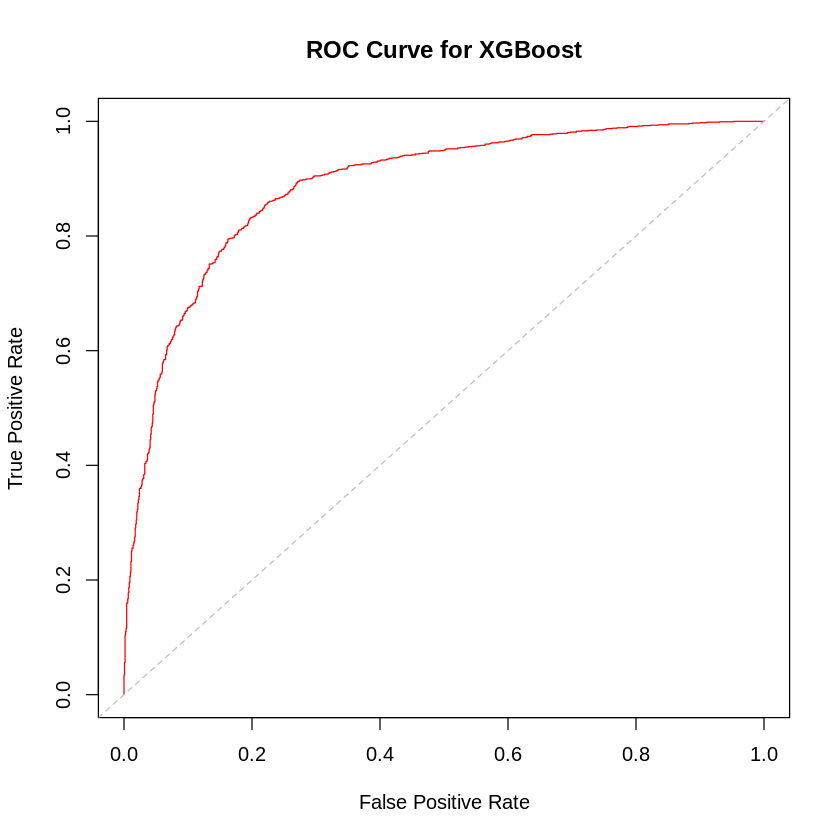

In [ ]:
x_test<-as.matrix(test_df[,c("turns","white_rating","black_rating","initial_time","rating_diff")])
dtest<-xgb.DMatrix(data=x_test)
xgb_probabilities<-predict(boosting_model,newdata=dtest)
roc_prediction<-prediction(xgb_probabilities,test_df$winner_numeric)
roc_performance<-performance(roc_prediction,"tpr","fpr")
plot(roc_performance,col="red",main="ROC Curve for XGBoost",xlab="False Positive Rate",ylab="True Positive Rate")
abline(a=0,b=1,lty=2,col="gray")